In [1]:
# Nguyen Hai Duong
# nhduong_3010@live.com
# Chonnam National University
# 2018.04.15

# Overview
### Data augmentation + EarlyStopping to avoid overfitting
- FER2013 dataset (face images + facial expression)
  + Goal: classifying facial exprression
  + Input: a 48x48 image
  + Output: facial expression (angry, disgust, fear, happy, neutral, sad, and surprise)
- Defining an CNN+MLP
- Training and evaluating an CNN+MLP

# Import libraries

In [2]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import time
import numpy as np
import matplotlib.pyplot as plt

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
num_classes = 7   # angry, disgust, fear, happy, neutral, sad, and surprise

# (1) Data

### Download data at https://drive.google.com/open?id=0BxINLo5jshCRbXpRcnl2SjJkdlk
This source code and npy files MUST be in the same location

In [4]:
trainingset = np.loadtxt('fer2013_training_onehot.csv', delimiter=',')
testingset = np.loadtxt('fer2013_publictest_onehot.csv', delimiter=',')

trainingset

array([[ 70.,  80.,  82., ...,   0.,   0.,   0.],
       [151., 150., 147., ...,   0.,   0.,   0.],
       [231., 212., 156., ...,   0.,   0.,   0.],
       ...,
       [ 74.,  81.,  87., ...,   1.,   0.,   0.],
       [222., 227., 203., ...,   0.,   0.,   0.],
       [195., 199., 205., ...,   1.,   0.,   0.]])

In [5]:
n_inputs = 2304
n_classes = 7
img_dim = 48

x_training = trainingset[:, 0:n_inputs]
y_training = trainingset[:, n_inputs:n_inputs + n_classes]

x_testing = testingset[:, 0:n_inputs]
y_testing = testingset[:, n_inputs:n_inputs + n_classes]

x_training = x_training.reshape(x_training.shape[0], 48, 48)
x_training = np.expand_dims(x_training, axis=4)

x_testing = x_testing.reshape(x_testing.shape[0], 48, 48)
x_testing = np.expand_dims(x_testing, axis=4)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


# (2) Declare model

In [6]:
# 64x64 portray image
input_image = Input(shape=(48, 48, 1), name='Input')

# conv, pooling layers + dropout
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv1_1')(input_image)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu', name='conv1_2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
x = Dropout(rate=0.25, name='conv_dropout1')(x)

x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_1')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding='valid', activation='relu', name='conv2_2')(x)
x = Conv2D(filters=218, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_3')(x)
x = Conv2D(filters=218, kernel_size=(3, 3), padding='valid', activation='relu', name='conv2_4')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
x = Dropout(rate=0.25, name='conv_dropout2')(x)

# similar to the MLP example!
# matrix ---> vector
x = Flatten(name='flatten')(x)

# FC layers + dropout
x = Dense(units=1024, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5, name='fc_dropout1')(x)

output_label = Dense(units=num_classes, activation='softmax', name='fc3_7ways_softmax')(x)

# define model
model = Model(inputs=input_image, outputs=output_label, name='emo_cnn')

# print model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 48, 48, 1)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 48, 48, 64)        640       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 46, 46, 64)        36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv_dropout1 (Dropout)      (None, 23, 23, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 23, 23, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 21, 21, 128)       147584    
__________

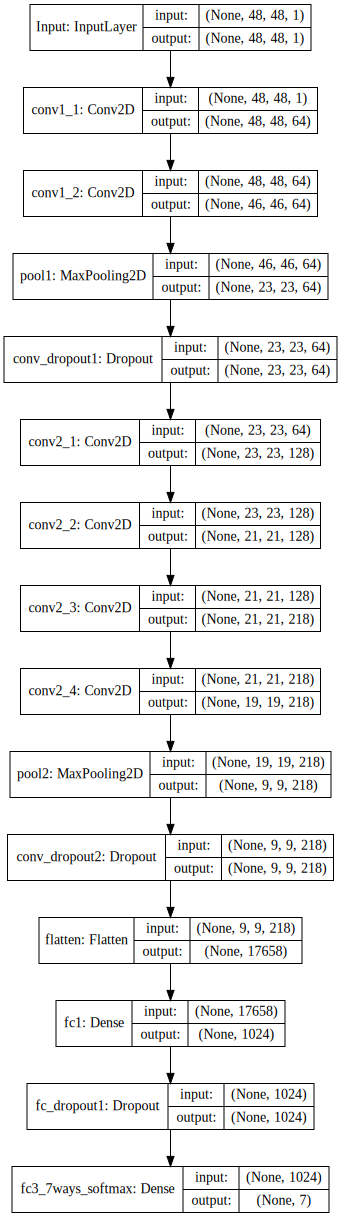

In [7]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# (3) Train defined model
- Note that the training history including loss and accuracy will be save in 'history' variable
- In case your system runs out of memory (OOM), try to decrease batch size

In [8]:
# Data augmentation
# based on https://keras.io/preprocessing/image/
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [9]:
# declare learning rate, loss function, and model metric
loss = 'categorical_crossentropy'
lr = 0.0001
model.compile(loss=loss, optimizer=Adam(lr=lr), metrics=['accuracy'])

# EarlyStopping: stop training early to avoid overfitting
early_stopping_after_epochs = 5
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_after_epochs)

# train the model
batch_size = 128
epochs = 100

starting_time = time.time()
history = model.fit_generator(datagen.flow(x_training, y_training, batch_size=batch_size),
                              steps_per_epoch=len(x_training) / batch_size,
                              validation_data=(x_testing, y_testing),
                              epochs=epochs,
                              callbacks=[early_stopping])
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Epoch 1/100
225/224 [==============================] - 26s 117ms/step - loss: 2.2824 - acc: 0.2322 - val_loss: 1.8679 - val_acc: 0.2527
Epoch 2/100
225/224 [==============================] - 24s 106ms/step - loss: 1.8169 - acc: 0.2486 - val_loss: 1.8343 - val_acc: 0.2536
Epoch 3/100
225/224 [==============================] - 24s 106ms/step - loss: 1.8064 - acc: 0.2556 - val_loss: 1.8042 - val_acc: 0.2650
Epoch 4/100
225/224 [==============================] - 24s 106ms/step - loss: 1.7976 - acc: 0.2559 - val_loss: 1.7512 - val_acc: 0.2948
Epoch 5/100
225/224 [==============================] - 24s 106ms/step - loss: 1.7829 - acc: 0.2646 - val_loss: 1.7241 - val_acc: 0.3151
Epoch 6/100
225/224 [==============================] - 24s 107ms/step - loss: 1.7640 - acc: 0.2729 - val_loss: 1.7159 - val_acc: 0.3279
Epoch 7/100
225/224 [==============================] - 24s 107ms/step - loss: 1.7357 - acc: 0.2932 - val_loss: 1.6406 - val_acc: 0.3709
Epoch 8/100
225/224 [===========================

### Training time
- Training time with GTX 1080 is about 22.7489 minutes for 57 epochs. The accuracy +2% without overfitting!
- Training time with Core i7 is around ??? minutes for ??? epochs

# (4) Evaluate trained model

In [10]:
score = model.evaluate(x_testing, y_testing)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3589/3589 [==============================] - 1s 348us/step
Test loss: 1.0158260697672779
Test accuracy: 0.6163276678782115


In [11]:
def get_emotion(ohv):
    indx = np.argmax(ohv)
        
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

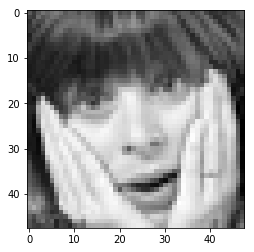

> testing image index: 2362
> true emotion: surprise
> predicted emotion: surprise


In [90]:
# 2163
img_indx = np.uint32(np.random.rand()*(testingset.shape[0] - 1))
sample = x_testing[img_indx, :]
sample = sample.reshape(48, 48)

pred_cls = model.predict(sample.reshape(1, 48, 48, 1))

plt.imshow(sample, cmap='gray')
plt.show()
print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (img_indx, get_emotion(y_testing[img_indx, :]), get_emotion(pred_cls)))